# PRÁCTICA 1: Explorando el Ecosistema de Transformers

**Objetivo**: Familiarizarse con Hugging Face y experimentar con diferentes arquitecturas de transformers.

En este notebook exploraremos:
- Las tres familias arquitectónicas: encoder-only, decoder-only, encoder-decoder
- In-context learning: zero-shot vs few-shot
- Hugging Face Hub: buscar y usar modelos
- Comparar diferentes modelos y tareas

## 1. Setup del Entorno

### Librerías necesarias
Primero instalamos las librerías necesarias de Hugging Face.

**Conceptos rápidos de librerías**:
- **transformers**: modelos y tokenizadores preentrenados con una API unificada.
- **datasets**: carga/streaming de datasets (GLUE, SQuAD, etc.) de forma eficiente.
- **accelerate**: utilidades para usar GPU/TPU y distribución sin cambiar mucho el código.
- **torch**: backend numérico y de deep learning (tensores, autograd, GPU).
- **evaluate**: métricas estandarizadas (accuracy, F1, BLEU, ROUGE, etc.).

### Configuración de modelos
El diccionario `MODELS` centraliza **todos** los modelos usados en el notebook:

**Encoder-only (BERT)**:
- `bert_sentiment`: DistilBERT fine-tuned para sentimiento (siempre ligero)
- `bert_base`: BERT base o DistilBERT según `FAST_MODE`
- `bert_ner`: BERT especializado en NER (siempre el mismo)

**Decoder-only (GPT)**:
- `gpt2`: DistilGPT-2 o GPT-2 según `FAST_MODE`

**Encoder-Decoder (T5/Flan)**:
- `t5`: T5-small (siempre, suficiente para demos)
- `flan`: Flan-T5 small o base según `FAST_MODE`

**Tareas especializadas**:
- `qa`: DistilBERT para Question Answering (siempre ligero)
- `zeroshot`: DistilBART o BART-large según `FAST_MODE`

**Filosofía**:
- Modelos pequeños (distil*, small) usan el mismo modelo independientemente de `FAST_MODE`
- Modelos medianos/grandes cambian según `FAST_MODE` para balancear velocidad vs. capacidad

In [ ]:
# Instalación de librerías necesarias
# !pip install -q transformers datasets evaluate accelerate torch

In [ ]:
# Imports básicos
from transformers import pipeline, AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from transformers import AutoModelForCausalLM, AutoModelForSeq2SeqLM
import torch
import numpy as np
import warnings
import os
import logging

# Suprimir warnings específicos
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suprimir warnings de TensorFlow/CUDA
os.environ['TRANSFORMERS_VERBOSITY'] = 'error'  # Solo errores críticos de transformers
logging.getLogger('transformers').setLevel(logging.ERROR)

# Configuración de dispositivo (GPU/CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
pipeline_device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Dispositivo para modelos: {device}")
print(f"Dispositivo para pipelines: {pipeline_device}")

# Modo rápido para reducir tiempos/descargas en clase
# Cambia a False para usar modelos completos (más lentos pero más capaces)
FAST_MODE = True

# Diccionario centralizado de TODOS los modelos usados en el notebook
MODELS = {
    # Encoder-only (BERT)
    "bert_sentiment": "distilbert-base-uncased-finetuned-sst-2-english",  # Siempre DistilBERT (ligero)
    "bert_base": "bert-base-uncased" if not FAST_MODE else "distilbert-base-uncased",
    "bert_ner": "dslim/bert-base-NER",  # Siempre este (específico para NER)
    
    # Decoder-only (GPT)
    "gpt2": "distilgpt2" if FAST_MODE else "gpt2",
    
    # Encoder-Decoder (T5/Flan)
    "t5": "t5-small",  # Siempre small (suficiente para demos)
    "flan": "google/flan-t5-small" if FAST_MODE else "google/flan-t5-base",
    
    # QA y Zero-shot
    "qa": "distilbert-base-cased-distilled-squad",  # Siempre DistilBERT (ligero)
    "zeroshot": "valhalla/distilbart-mnli-12-1" if FAST_MODE else "facebook/bart-large-mnli",
}

print(f"\nFAST_MODE: {FAST_MODE}")
print("\nModelos seleccionados:")
for key, value in MODELS.items():
    print(f"  {key:20} → {value}")

## 2. Experimentando con las Tres Familias

### 2.1 Familia 1: Encoder-only (BERT)

#### Base teórica
Los modelos **encoder-only** como BERT (Bidirectional Encoder Representations from Transformers) son bidireccionales y excelentes para tareas de **comprensión** de texto.

**Características arquitectónicas**:
- **Bidireccionalidad**: ven toda la secuencia simultáneamente (izquierda + derecha)
- **Entrenamiento**: Masked Language Modeling (MLM) - se enmascaran tokens y el modelo los predice usando todo el contexto
- **Uso típico**: clasificación, NER (Named Entity Recognition), QA extractivo

**Conceptos clave**:
- **MLM**: Durante el pre-entrenamiento, se enmascaran aleatoriamente ~15% de los tokens y el modelo aprende a predecirlos usando contexto bidireccional.
- **Embeddings contextuales**: Cada token se representa como un vector que captura su significado en contexto (a diferencia de embeddings estáticos como Word2Vec).
- **Atención multi-cabeza**: El mecanismo de atención tiene varias "cabezas" que capturan distintos tipos de relaciones (sintaxis, semántica, dependencias).
- **Token [CLS]**: Token especial al inicio; su embedding final se usa como representación de toda la secuencia en tareas de clasificación.

#### Herramientas: `pipeline`
La clase `pipeline` de Hugging Face es una **interfaz de alto nivel** que encapsula:
1. **Tokenización**: convierte texto en IDs de tokens que entiende el modelo
2. **Inferencia**: pasa los tokens por el modelo
3. **Post-procesado**: convierte la salida del modelo en formato legible (etiquetas, probabilidades, etc.)

Sintaxis: `pipeline(task, model=nombre_modelo, device=dispositivo)`
- `task`: tipo de tarea ("sentiment-analysis", "ner", "question-answering", etc.)
- `model`: nombre del modelo en Hugging Face Hub o ruta local
- `device`: "cuda:0" para GPU, "cpu" para CPU

In [ ]:
# Ejercicio 1a: Usar pipeline para clasificación de sentimiento
# Pipeline ya tokeniza, infiere y post-procesa automáticamente

sentiment_classifier = pipeline(
    "sentiment-analysis",
    model=MODELS["bert_sentiment"],
    device=pipeline_device
)

# Probar con diferentes textos
texts = [
    "I love this movie! It's absolutely fantastic.",
    "This is the worst experience I've ever had.",
    "The weather is okay, nothing special.",
    "I'm not sure how I feel about this."
]

print("=" * 60)
print(f"ANÁLISIS DE SENTIMIENTO CON {MODELS['bert_sentiment']}")
print("=" * 60)

for text in texts:
    result = sentiment_classifier(text)[0]
    print(f"\nTexto: {text}")
    print(f"Sentimiento: {result['label']}")
    print(f"Confianza: {result['score']:.4f}")

#### Herramientas: `AutoTokenizer` y `AutoModel`
Cuando necesitas **control fino** sobre el modelo (no solo inferencia rápida con `pipeline`), usas:

- **`AutoTokenizer.from_pretrained(nombre)`**: Carga el tokenizador correspondiente al modelo.
  - Convierte texto → IDs de tokens
  - Añade tokens especiales ([CLS], [SEP], [PAD])
  - Devuelve tensores compatibles con PyTorch/TensorFlow
  
- **`AutoModel.from_pretrained(nombre)`**: Carga el modelo base (sin cabeza de tarea específica).
  - Devuelve embeddings crudos (última capa oculta, pooler output, etc.)
  - Útil para: obtener representaciones, fine-tuning personalizado, análisis interno

**¿Qué es una "cabeza de tarea"?**

Un modelo transformer tiene dos componentes:
1. **Cuerpo base (backbone)**: Las capas transformer que aprenden representaciones generales (por ejemplo, las 12 capas de BERT-base que convierten texto en vectores de 768 dimensiones)
2. **Cabeza (head)**: Capa(s) adicional(es) encima del cuerpo para una tarea específica

**Clases `Auto*` para cargar modelos con diferentes arquitecturas:**

Las clases `AutoModel*` son **cargadores inteligentes** que instancian el modelo adecuado según el nombre que proporciones. Cada variante carga modelos con una arquitectura específica:

- **`AutoModel`**: Carga modelos **sin cabeza de tarea** → Solo el cuerpo base que devuelve embeddings
  - Úsalo para: análisis de representaciones, embeddings, visualizaciones, fine-tuning personalizado
  
- **`AutoModelForSequenceClassification`**: Carga modelos **con cabeza de clasificación**
  - Arquitectura: cuerpo base + capa lineal sobre [CLS] → logits de clasificación
  - Busca modelos fine-tuned para: análisis de sentimiento, detección de spam, clasificación de tópicos
  
- **`AutoModelForTokenClassification`**: Carga modelos **con cabeza de clasificación por token**
  - Arquitectura: cuerpo base + capa lineal sobre cada token → etiqueta por token
  - Busca modelos fine-tuned para: NER (personas, lugares, organizaciones), POS tagging
  
- **`AutoModelForQuestionAnswering`**: Carga modelos **con cabeza de QA**
  - Arquitectura: cuerpo base + capas que predicen inicio/fin de respuesta
  - Busca modelos fine-tuned para: QA extractivo (SQuAD, etc.)

**Importante**: Estas clases **no realizan las tareas por sí mismas**, sino que cargan modelos que típicamente han sido fine-tuned para esas tareas. Debes buscar en Hugging Face Hub modelos apropiados para tu tarea específica.

```
Flujo sin cabeza:
Texto → Tokenizador → BERT (12 capas) → Embeddings [batch, seq_len, 768]
                                            ↓
                              Tú decides qué hacer con ellos

Flujo con cabeza de clasificación:
Texto → Tokenizador → BERT (12 capas) → Embeddings [batch, seq_len, 768]
                                            ↓
                            [CLS] token → Capa lineal → [positivo, negativo]
```

- **`.to(device)`**: Mueve el modelo a GPU/CPU según configuración.

In [ ]:
# Ejercicio 1b: Explorar los embeddings de BERT

model_name = MODELS["bert_base"]
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Especificar attn_implementation="eager" para evitar el warning con output_attentions
model = AutoModel.from_pretrained(model_name, attn_implementation="eager").to(device)

text = "The cat sat on the mat"
inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)

print(f"Modelo: {model_name}")
print(f"Texto original: {text}")
print(f"\nTokens: {tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])}")
print(f"IDs de tokens: {inputs['input_ids'][0].tolist()}")

# Obtener embeddings (sin gradientes, solo inferencia)
with torch.no_grad():
    outputs = model(**inputs)
    last_hidden_state = outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]

print(f"\nForma de embeddings: {last_hidden_state.shape}")
print(f"  → (batch_size={last_hidden_state.shape[0]}, seq_len={last_hidden_state.shape[1]}, hidden_dim={last_hidden_state.shape[2]})")
print(f"\nPrimeros 5 valores del embedding del token [CLS]:")
print(last_hidden_state[0, 0, :5].cpu().numpy())

#### Visualización de Atención: Entendiendo el mecanismo interno

**Herramienta**: `output_attentions=True`
- Parámetro del modelo que activa la devolución de los pesos de atención de todas las capas.
- Permite inspeccionar **qué tokens atienden a qué otros tokens** en cada capa y cabeza.
- Útil para: interpretabilidad, debugging, análisis lingüístico.

**Cómo leer un mapa de atención**:
- **Filas**: tokens que consultan (queries)
- **Columnas**: tokens a los que prestan atención (keys)
- **Valores altos**: mayor foco entre pares de tokens
- **Diagonal alta**: auto-atención (cada token se atiende a sí mismo)
- **Múltiples cabezas**: cada cabeza capta patrones distintos (sintaxis, dependencias, entidades, etc.)
- **Tokens especiales**: [CLS] y [SEP] suelen concentrar o dispersar atención según la capa
- **Softmax por fila**: la atención está normalizada (cada fila suma 1)

In [ ]:
# Ejercicio 1c: Visualizar mecanismo de atención

# Imports para visualización (solo cuando se necesitan)
import matplotlib.pyplot as plt
import seaborn as sns

def get_attention_weights(model, inputs, layer_idx=-1, head_idx=0):
    """
    Extrae los pesos de atención de una capa y cabeza específicas.
    
    Args:
        model: Modelo transformer con capacidad de output_attentions
        inputs: Inputs tokenizados del modelo
        layer_idx: Índice de la capa (-1 para última capa, 0 para primera)
        head_idx: Índice de la cabeza de atención (0 para primera cabeza)
    
    Returns:
        attention: Array numpy con pesos de atención [seq_len, seq_len]
        num_layers: Número total de capas
        num_heads: Número total de cabezas de atención
        attentions: Tuple con todos los tensores de atención de todas las capas
    """
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
        attentions = outputs.attentions  # Tuple de tensores, uno por capa
    
    num_layers = len(attentions)
    num_heads = attentions[0].shape[1]
    
    # Extraer atención de la capa y cabeza especificadas
    attention = attentions[layer_idx][0, head_idx].cpu().numpy()
    
    return attention, num_layers, num_heads, attentions


def plot_attention_heatmap(attention, tokens, layer_idx, head_idx, figsize=(12, 10)):
    """
    Visualiza los pesos de atención como mapa de calor.
    
    Args:
        attention: Matriz de atención [seq_len, seq_len]
        tokens: Lista de tokens
        layer_idx: Índice de la capa visualizada
        head_idx: Índice de la cabeza visualizada
        figsize: Tamaño de la figura (ancho, alto)
    """
    plt.figure(figsize=figsize)
    sns.heatmap(
        attention, 
        xticklabels=tokens, 
        yticklabels=tokens, 
        cmap='YlOrRd',  # Mejor paleta para visualizar atención
        annot=True, 
        fmt='.3f',  # 3 decimales para más precisión
        cbar_kws={'label': 'Peso de atención'},
        square=True,  # Celdas cuadradas
        linewidths=0.5,  # Líneas entre celdas
        linecolor='gray'
    )
    plt.title(f'Mapa de Atención - Capa {layer_idx}, Cabeza {head_idx}\n'
              f'Las filas muestran a qué tokens atiende cada token', 
              fontsize=14, pad=20)
    plt.xlabel('Tokens (Key) - A qué se atiende', fontsize=12)
    plt.ylabel('Tokens (Query) - Quién atiende', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


def print_attention_table(attention, tokens):
    """
    Imprime la matriz de atención como tabla de texto formateada.
    
    Args:
        attention: Matriz de atención [seq_len, seq_len]
        tokens: Lista de tokens
    """
    print("\n" + "=" * 80)
    print("MATRIZ DE ATENCIÓN EN FORMATO TEXTO (copiable)")
    print("=" * 80)
    
    # Encabezado con los tokens
    header = "Token".ljust(12) + " | " + " | ".join([tok.ljust(6) for tok in tokens])
    print(header)
    print("-" * len(header))
    
    # Cada fila con sus valores
    for i, token in enumerate(tokens):
        row_values = " | ".join([f"{attention[i, j]:.3f}" for j in range(len(tokens))])
        print(f"{token.ljust(12)} | {row_values}")
    
    print("\n" + "=" * 80)
    print("VERIFICACIÓN: Suma de cada fila (debe ser ≈1.0 por softmax)")
    print("=" * 80)
    for i, token in enumerate(tokens):
        row_sum = attention[i].sum()
        print(f"{token.ljust(12)}: {row_sum:.6f}")


# ============================================================================
# EJEMPLO DE USO: Visualizar última capa, primera cabeza
# ============================================================================

# Obtener tokens
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# Obtener pesos de atención
attention, num_layers, num_heads, _ = get_attention_weights(
    model, inputs, 
    layer_idx=-1,  # Última capa
    head_idx=0     # Primera cabeza
)

print(f"Número de capas con atención: {num_layers}")
print(f"Número de cabezas por capa: {num_heads}")
print(f"Forma de atención: {attention.shape}")
print(f"  → (seq_len={attention.shape[0]}, seq_len={attention.shape[1]})")

# Visualizar como gráfico
plot_attention_heatmap(attention, tokens, layer_idx=num_layers-1, head_idx=0)

# Imprimir como tabla
# print_attention_table(attention, tokens)


## Interpretación práctica

### ¿Por qué vemos estos patrones de atención?

Las cabezas de atención en BERT **no son uniformes**: cada capa y cada cabeza dentro de esa capa aprende a especializarse en capturar diferentes aspectos del lenguaje durante el pre-entrenamiento.

> Nota el número de capas y cabezas varía según el modelo (ej: BERT-base tiene 12 capas y 12 cabezas por capa) pero en los modelos destilados o más pequeños puede ser menor (ej: DistilBERT tiene 6 capas y 12 cabezas por capa).

#### Especialización por capas:

**Capas iniciales (0-3):**
- Capturan patrones **locales y sintácticos**: relaciones entre palabras cercanas, estructuras gramaticales básicas
- Ejemplo: concordancia sujeto-verbo, modificadores adyacentes
- Alta atención en la **diagonal** (auto-atención) y **vecinos inmediatos**

**Capas intermedias (4-7):**
- Comienzan a abstraer: **dependencias sintácticas más largas**, estructura de frases
- Ejemplo: relaciones entre el verbo y sus argumentos dispersos en la oración
- Mezcla de patrones locales y globales

**Capas finales (8-12):**
- Se especializan según la **tarea específica** para la que se fine-tunea el modelo
- En modelos base (sin fine-tuning), concentran atención en **tokens especiales** como `[CLS]` y `[SEP]`
- `[SEP]` actúa como **agregador**: captura contexto global, maneja límites de oración, o simplemente "absorbe" atención cuando no hay relaciones complejas que procesar
- `[CLS]` se usa para **representación de secuencia completa** en tareas de clasificación

#### ¿Por qué `[SEP]` domina?

Para oraciones simples como "the cat sat on the mat", las capas finales no necesitan capturar dependencias complejas en cada cabeza.

Este comportamiento se vuelve más sofisticado con:
- **Oraciones complejas**: subordinadas, ambigüedades semánticas, referencias anafóricas
- **Múltiples oraciones**: donde `[SEP]` realmente delimita segmentos y gestiona información inter-sentencial

##### Para explorar más
- **Varía la complejidad**: Prueba "The cat that chased the mouse sat on the mat.", "It looked exhausted"
- **¿Quién estaba cansado?**: el sofá, el ratón o el gato

## Comparar en diversas capas.

- **Compara capas**: Visualiza capas intermedias con el mismo texto.
- **Múltiples cabezas**: Cada cabeza en la misma capa captura distintas relaciones (sintaxis, semántica, posicionalidad)

In [ ]:
# Ejercicio 1d: Explorar diferentes capas y cabezas de atención

# Obtener TODAS las atenciones una sola vez (eficiente)
_, _, _, all_attentions = get_attention_weights(model, inputs, layer_idx=0, head_idx=0)

# Configuración de capas y cabezas a visualizar (4x4 grid)
layers_to_plot = [0, num_layers // 3, 2 * num_layers // 3, num_layers - 1]
heads_to_plot = [0, num_heads // 4, num_heads // 2, num_heads - 1]

fig, axes = plt.subplots(4, 4, figsize=(20, 20))
fig.suptitle('Mapas de Atención: Diferentes Capas y Cabezas', fontsize=20, y=0.995)

for i, layer_idx in enumerate(layers_to_plot):
    for j, head_idx in enumerate(heads_to_plot):
        # Extraer atención directamente del tensor pre-calculado
        attention_weights = all_attentions[layer_idx][0, head_idx].cpu().numpy()
        
        ax = axes[i, j]
        sns.heatmap(
            attention_weights,
            xticklabels=tokens,
            yticklabels=tokens,
            cmap='YlOrRd',
            annot=False,
            square=True,
            linewidths=0.3,
            linecolor='gray',
            cbar_kws={'label': 'Atención'},
            ax=ax
        )
        
        ax.set_title(f'Capa {layer_idx}, Cabeza {head_idx}', fontsize=12, pad=10)
        ax.set_xlabel('Tokens (Key)', fontsize=10)
        ax.set_ylabel('Tokens (Query)', fontsize=10)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        ax.tick_params(axis='y', rotation=0, labelsize=8)

plt.tight_layout()
plt.show()

# Consolidación

⚠️❓⚠️❓⚠️❓⚠️

En la siguiente imagen puedes observar la atención de la frase:

- "The cat that chased the mouse sat on the mat. It looked exhausted"

Analiza la capa 5 y la cabeza 3. **¿Existe alguna relación entre tokens destacable?**

En la siguiente celda escribe una frase similar con distintas referencia pero no muy larga y genera un patrón similar.

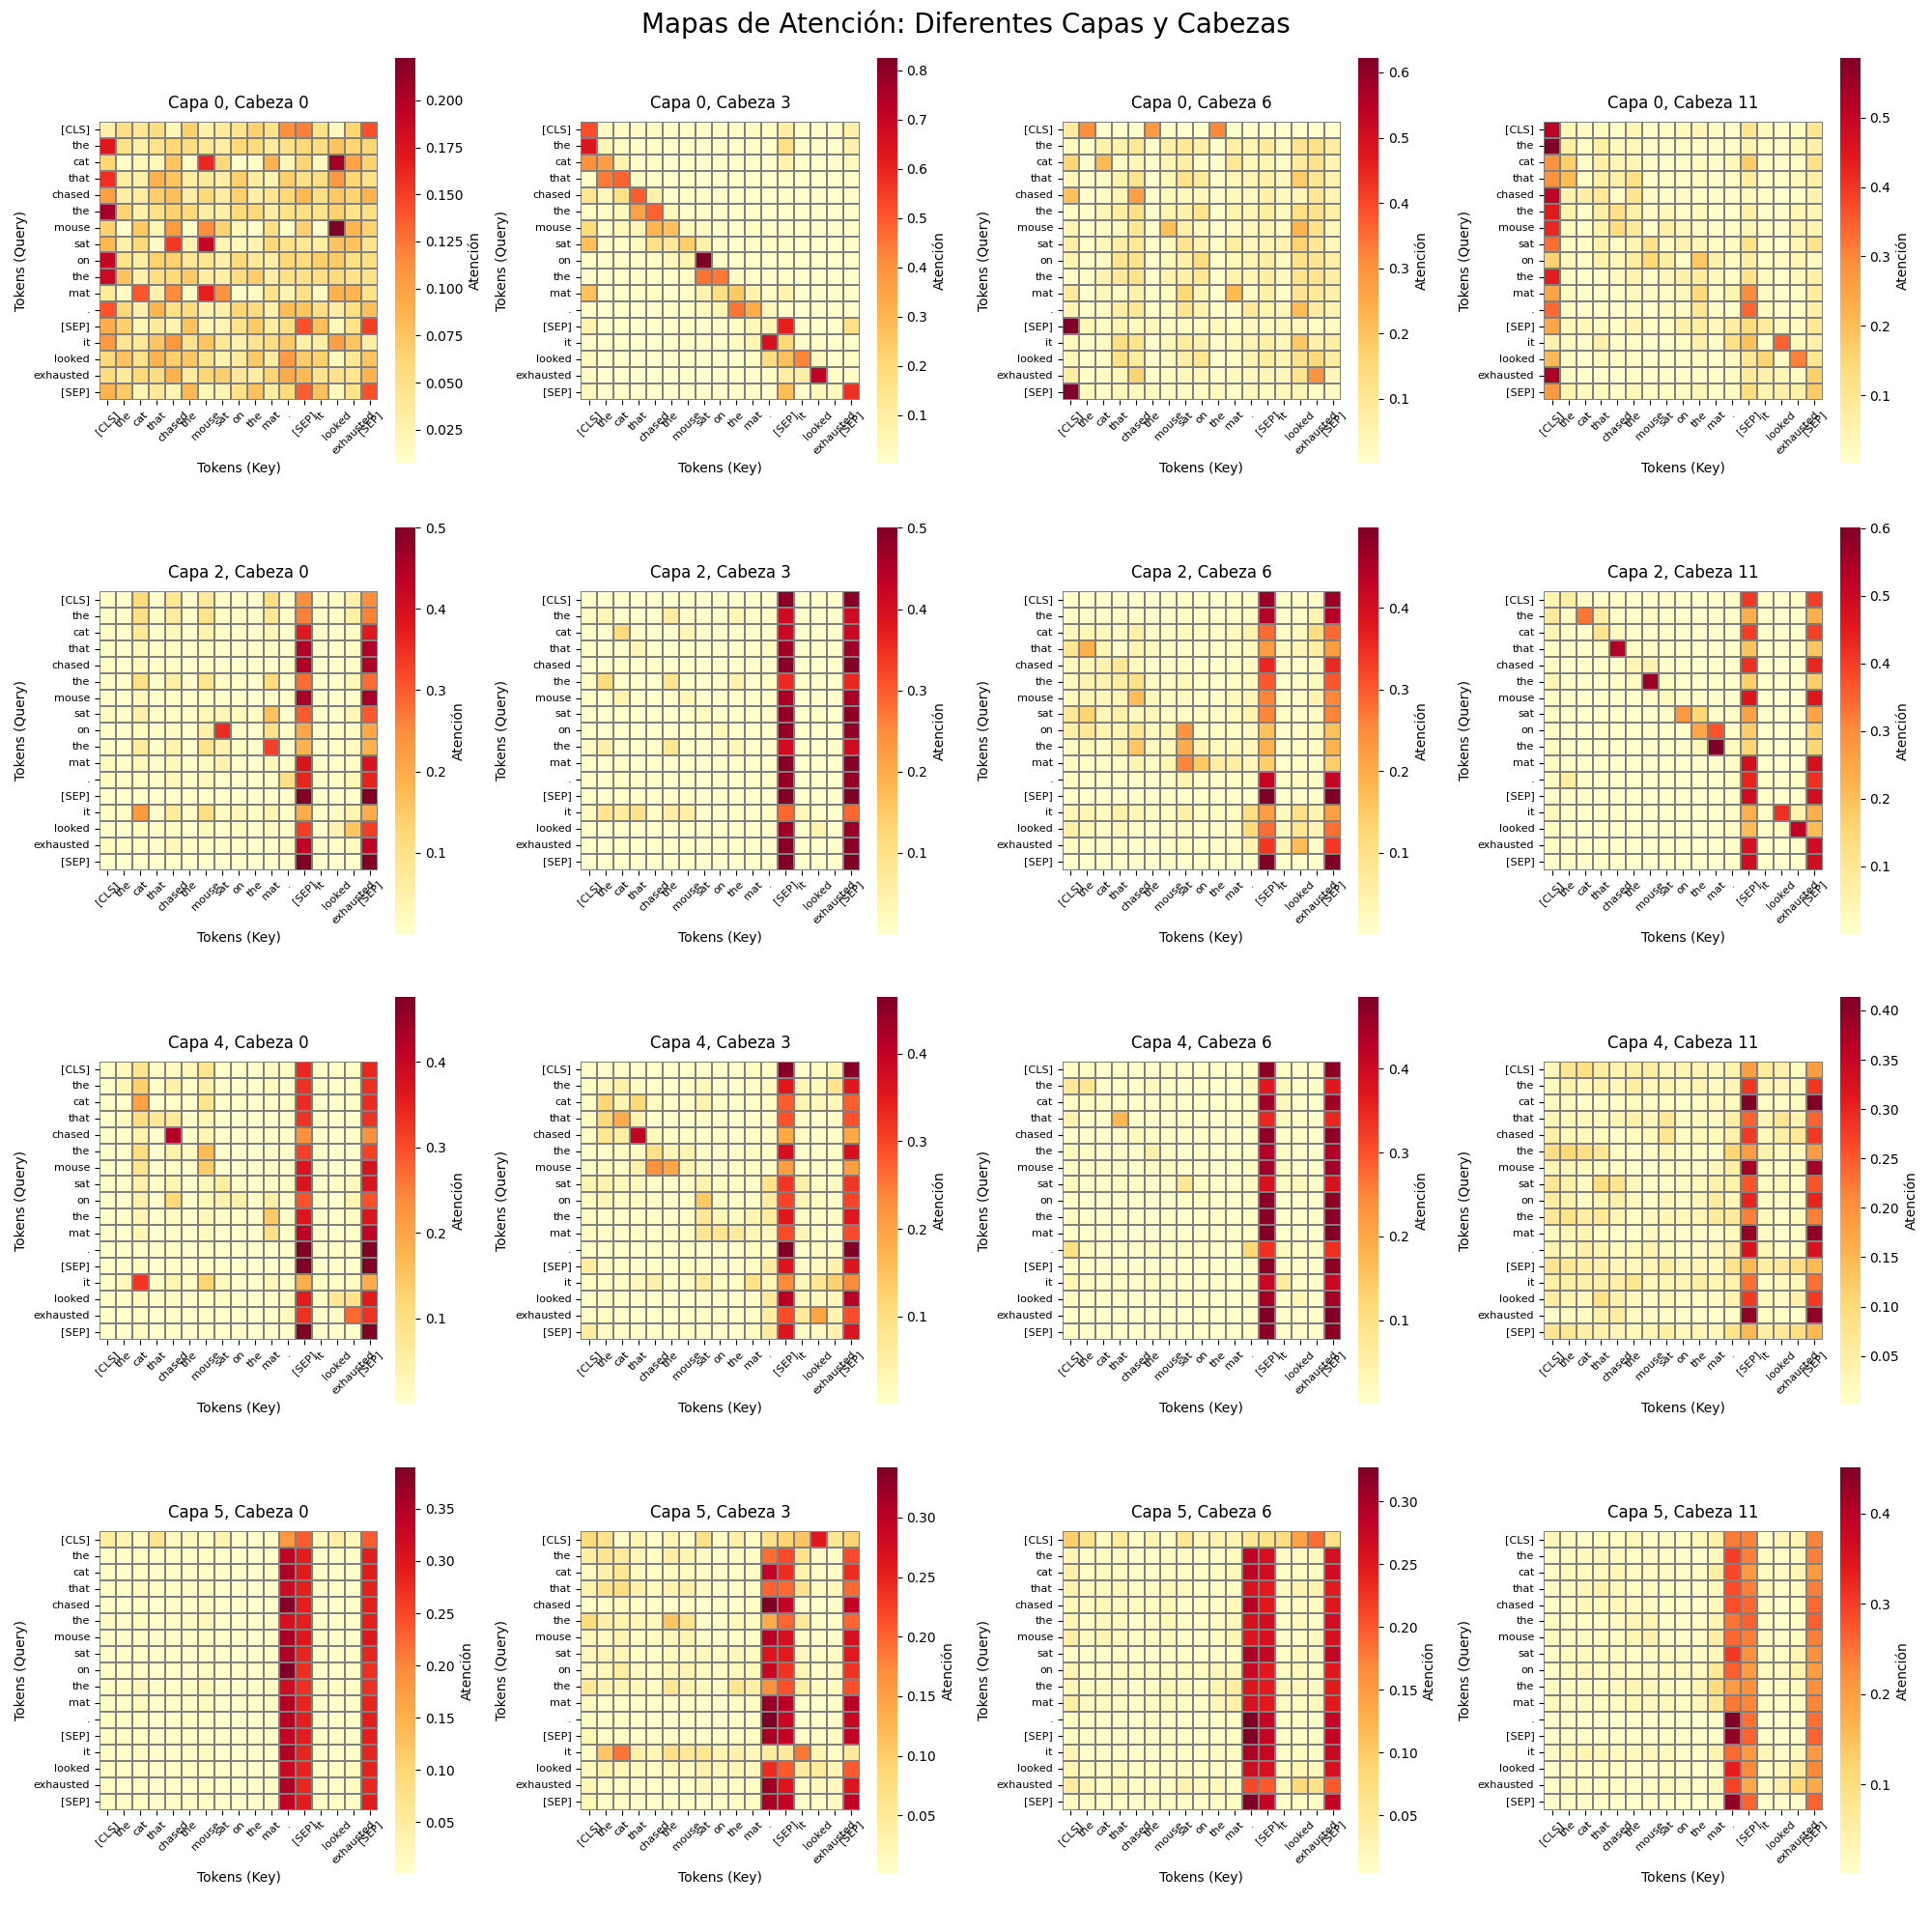

In [ ]:
# Crea tu propia frase

frase_1 = ""
frase_2 = ""

## Código aquí

# NOTA: puedes usar el código de la celda anterior


### 2.2 Familia 2: Decoder-only (GPT-2)

#### Base teórica
Los modelos **decoder-only**, como **GPT (Generative Pre-trained Transformer)**, son **autoregresivos** y están optimizados para tareas de **generación de texto**.

**Características arquitectónicas**:
- **Atención causal (masked self-attention)**: cada token solo puede atender a los anteriores, nunca a los futuros.  
- **Entrenamiento**: mediante **Causal Language Modeling (CLM)**. El modelo aprende a predecir el siguiente token dado el contexto previo.  
- **Entrenamiento paralelo**: aunque el modelo genera texto de forma secuencial en inferencia, **durante el entrenamiento todas las posiciones de la secuencia se procesan en paralelo**, aprovechando la arquitectura del transformer.  
- **Usos típicos**: generación de texto, autocompletado, diálogo, generación de código.

**Conceptos clave**:
- **CLM**: el modelo aprende la distribución \( P(token_t \mid tokens_{1...t-1}) \), es decir, predice cada token a partir de los anteriores.  
- **Autoregresivo**: en inferencia, genera la secuencia paso a paso; cada nuevo token depende de los previos.  
- **Máscara causal**: impide que el token \( i \) acceda a información de los tokens \( i+1, i+2, \dots \).

#### Estrategias de Decoding
En la generación de texto, existen distintas estrategias para seleccionar el siguiente token, como **greedy decoding**, **sampling**, **top-k** o **nucleus sampling (top-p)**, cada una con distintos compromisos entre coherencia y diversidad.


1. **Greedy Decoding** (`do_sample=False`):
   - Siempre elige el token más probable
   - Determinista y coherente
   - Puede ser repetitivo y poco creativo

2. **Sampling con Temperature** (`do_sample=True, temperature=T`):
   - Muestrea de la distribución de probabilidad
   - `T < 1`: más conservador (aumenta probabilidades de tokens top)
   - `T > 1`: más creativo (aplana distribución, permite tokens menos probables)
   - `T = 1`: distribución original del modelo

3. **Top-k Sampling** (`top_k=k`):
   - Solo muestrea de los k tokens más probables
   - Limita opciones pero mantiene diversidad

4. **Top-p (Nucleus) Sampling** (`top_p=p`):
   - Muestrea del conjunto mínimo de tokens cuya probabilidad acumulada ≥ p
   - Adaptativo: pocas opciones cuando hay un token dominante, más cuando hay incertidumbre

#### Herramienta: `model.generate()`
Método clave para generación de texto en modelos autoregresivos:
- `max_length`: longitud máxima de la secuencia generada
- `do_sample`: True para sampling, False para greedy
- `temperature`, `top_k`, `top_p`: controlan la estrategia de muestreo
- `num_return_sequences`: cuántas secuencias generar en paralelo

In [ ]:
# Ejercicio 2a: Generar texto con GPT-2 (decoder-only)

model_name = MODELS["gpt2"]

# Cargar tokenizer y configurar pad_token
tokenizer_gpt = AutoTokenizer.from_pretrained(model_name)
tokenizer_gpt.pad_token = tokenizer_gpt.eos_token

generator = pipeline(
    "text-generation",
    model=model_name,
    tokenizer=tokenizer_gpt,
    device=pipeline_device
)

prompt = "Once upon a time in a distant galaxy"
print(f"\nPrompt: '{prompt}'\n")

# Generar con greedy decoding (determinista)
result = generator(
    prompt,
    max_new_tokens=50,  # Usar max_new_tokens en lugar de max_length
    num_return_sequences=1,
    do_sample=False,
    pad_token_id=tokenizer_gpt.eos_token_id
)

print("Generación (Greedy Decoding):")
print("-" * 60)
print(result[0]['generated_text'])

In [ ]:
# Ejercicio 2b: Experimentar con diferentes parámetros de generación

configs = [
    {"name": "Greedy (determinista)", "do_sample": False},
    {"name": "Sampling con temperature=0.7", "do_sample": True, "temperature": 0.7},
    {"name": "Sampling con temperature=1.5", "do_sample": True, "temperature": 1.5},
    {"name": "Top-k sampling (k=50)", "do_sample": True, "top_k": 50},
    {"name": "Top-p sampling (p=0.9)", "do_sample": True, "top_p": 0.9, "top_k": 0},
]

def print_generation(config, prompt):
    name = config.pop("name")
    result = generator(
        prompt,
        max_new_tokens=50,  # Usar max_new_tokens en lugar de max_length
                            # ignoring the number of tokens in the prompt.
        num_return_sequences=1,
        pad_token_id=tokenizer_gpt.eos_token_id, # Padding del modelo usado
        **config
    )
    print(f"Estrategia: {name}")
    display(result[0]['generated_text'])

print_generation(configs[0], prompt)
print_generation(configs[1], prompt)
print_generation(configs[2], prompt)
print_generation(configs[3], prompt)
print_generation(configs[4], prompt)

# Consolidación

⚠️❓⚠️❓⚠️❓⚠️

Objetivo: Experimenta con los parámetros para crear continuaciones interesantes, coherentes o creativas de estas historias.


In [ ]:
escenarios = [
    {
        "prompt": "The old wizard opened the ancient book and whispered",
        "tipo": "fantasía",
        "objetivo": "Hacer que suene místico y coherente"
    },
    {
        "prompt": "In the year 2157, humanity discovered",
        "tipo": "ciencia ficción",
        "objetivo": "Balance entre creatividad y coherencia científica"
    },
    {
        "prompt": "The detective looked at the evidence and realized",
        "tipo": "misterio",
        "objetivo": "Mantener suspense y lógica"
    }
]

In [ ]:
# Escenario 1: Fantasía


In [ ]:
# Escenario 2: Ciencia ficción


In [ ]:
# Escenario 3: Misterio

⚠️❓⚠️❓⚠️❓⚠️

¿Puedes hacer que GPT-2 escriba un plot twist sorprendente?

- Puedes usar generaciones consecutivas con diferentes parámetros de sampling.

Inicio de la historia:

- "A student from the famous ETSISI was heading to class when suddenly"

In [ ]:
# Genera tu historia con un plot twist

### 2.3 Familia 3: Encoder-Decoder (T5)

#### Base teórica
Los modelos **encoder-decoder** como T5 (Text-to-Text Transfer Transformer) combinan lo mejor de ambos mundos y son flexibles para **transformación** de texto.

**Características arquitectónicas**:
- **Encoder bidireccional**: procesa la entrada viendo todo el contexto (como BERT)
- **Decoder autoregresivo**: genera la salida token a token (como GPT)
- **Paradigma Text-to-Text**: todas las tareas NLP se formulan como texto → texto
- **Uso típico**: traducción, resumen, QA generativo, paráfrasis

**Conceptos clave**:
- **Seq2Seq**: arquitectura secuencia-a-secuencia; el encoder comprime la entrada en representaciones, el decoder las usa para generar salida
- **Text-to-Text**: unificación de tareas mediante prefijos:
  - `"translate English to German: Hello"` → `"Hallo"`
  - `"summarize: [long text]"` → `"[summary]"`
  - `"question: X context: Y"` → `"answer"`
- **Cross-attention**: el decoder atiende a las representaciones del encoder (además de auto-atención)
- **Ventaja**: una sola interfaz para múltiples tareas; facilita transfer learning

#### Herramientas específicas
- **`T5ForConditionalGeneration`**: clase especializada para modelos T5 (a diferencia de AutoModel genérico)
- **`AutoTokenizer` con `use_fast=True`**: usa tokenizador rápido (Rust) que evita dependencia de SentencePiece
- **`model.generate()`**: igual que en GPT, pero aquí el encoder procesa input y el decoder genera output

In [ ]:
# Ejercicio 3a: Cargar T5 para múltiples tareas

# Import específico para T5 (solo cuando se necesita)
from transformers import T5ForConditionalGeneration

model_name = MODELS["t5"]
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)

def generate_with_t5(prompt, max_length=100):
    """Helper para generar con T5 - encapsula tokenización y generación"""
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(inputs.input_ids, max_length=max_length)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)



## Modelo pequeño T5

⚠️❓⚠️❓⚠️❓⚠️

El modelo usado es pequeño y no está ajustado (fine-tuned) para tareas específicas, por lo que los resultados pueden ser limitados. Sin embargo, es suficiente para demostrar el flujo de trabajo y la arquitectura encoder-decoder.

Si partimos del modelo grande preentrenado y los especializamos en alguna tarea específica (downstream fine-tuning), los resultados mejorarían significativamente.

> NOTA: No he conseguido que traduzca al Español

In [ ]:
# Ejercicio 3b: Traducción con T5

print("\n1. TRADUCCIÓN")
print("-" * 60)

text_en = "Hello, how are you doing today?"
prompt = f"translate English to German: {text_en}"

translation = generate_with_t5(prompt)

print(f"Inglés: {text_en}")
print(f"Alemán: {translation}")

# Otro ejemplo
text_en2 = "The weather is beautiful today."
prompt2 = f"translate English to French: {text_en2}"

translation2 = generate_with_t5(prompt2)

print(f"\nInglés: {text_en2}")
print(f"Francés: {translation2}")

In [ ]:
# Ejercicio 3c: Resumen con T5

print("\n2. RESUMEN")
print("-" * 60)

long_text = """
Artificial intelligence (AI) is intelligence demonstrated by machines, as opposed to intelligence 
displayed by humans or animals. Leading AI textbooks define the field as the study of intelligent agents, 
which are systems that perceive their environment and take actions that maximize their chances of achieving 
their goals. Some popular accounts use the term artificial intelligence to describe machines that mimic 
cognitive functions that humans associate with the human mind, such as learning and problem solving. 
AI research has been defined as the field of study of intelligent agents, which refers to any system that 
perceives its environment and takes actions that maximize its chance of achieving its goals.
"""

prompt = f"summarize: {long_text}"
summary = generate_with_t5(prompt, max_length=50)
print(f"Texto original ({len(long_text)} caracteres):")
print(f"\nResumen ({len(summary)} caracteres):")
print(summary)

prompt = f"summarize in just one sentence: {long_text}"
summary = generate_with_t5(prompt, max_length=50)
print(f"Resumen en una sola frase ({len(summary)} caracteres):")
print(summary)


In [ ]:
# Ejercicio 3d: Otras tareas con T5

# Question Answering extractivo
context = "The Amazon rainforest is located in South America. It is the largest rainforest in the world."
question = "Where is the Amazon rainforest located?"
prompt = f"question: {question} context: {context}"

answer = generate_with_t5(prompt)
print(f"\nQuestion Answering:")
print(f"Pregunta: {question}")
print(f"Respuesta: {answer}")

# Consolidación T5

⚠️❓⚠️❓⚠️❓⚠️

**IMPORTANTE: Limitaciones del modelo T5-small**

El modelo `t5-small` usado en este notebook **NO está especializado** en las tareas que hemos probado (traducción, resumen, QA). Es un modelo base pre-entrenado de manera general, por lo que **es normal que los resultados no sean buenos**.

### Otras pruebas

#### Modelos más grandes de T5
- `t5-base` (247M parámetros): Mejor rendimiento general
- `t5-large` (770M parámetros): Resultados significativamente mejores
- `t5-3b` / `t5-11b`: Modelos grandes (requieren GPU potente)

#### Modelos especializados (fine-tuned)**
- Para traducción: `t5-base-en-de` (fine-tuned en pares específicos)
- Para resumen: `t5-base-finetuned-summarize-news`
- Para corrección gramatical: `prithivida/grammar_error_correcter_v1`
- Para paráfrasis: `ramsrigouthamg/t5-large-paraphraser-diverse-high-quality`

#### Siguientes secciones

**Usar Flan-T5**
- `google/flan-t5-base` o `google/flan-t5-large`
- Ya vienen con instrucción-following, mejores resultados en zero-shot
- Los usaremos en la siguiente sección (In-Context Learning)

## 3. In-Context Learning con Modelos Grandes

#### Fundamento teórico: aprendizaje sin actualizar parámetros
El **In-Context Learning (ICL)** es una **capacidad emergente** de los modelos de lenguaje grandes (LLMs): el modelo **aprende a partir de ejemplos incluidos en el prompt**, sin necesidad de modificar sus pesos ni realizar entrenamiento adicional.

**Diferencia clave**:
- **Transfer Learning tradicional**: se entrena el modelo en dos fases → *pre-training* y *fine-tuning* (actualización de parámetros mediante backpropagation).
- **In-Context Learning**: solo se produce durante la *inferencia*; el modelo adapta su comportamiento usando la información del contexto proporcionado.

#### Modalidades principales

1. **Zero-shot**
   - **Definición**: el modelo recibe únicamente instrucciones, sin ejemplos previos.  
     Ejemplo:  
     ```text
     Classify sentiment: I love this! Answer:
     ```
   - **Ventajas**: inmediato, sin necesidad de datos adicionales.  
   - **Limitaciones**: resultados sensibles a la redacción del prompt o al formato esperado.

2. **One-shot**, **Few-shot**
   - **Definición**: se proporcionan instrucciones un ejemplo o unos pocos ejemplos (normalmente entre 2 y 5).  
     Ejemplo:  
     ```text
     Text: Great! → Positive
     Text: Terrible → Negative
     Text: Amazing! →
     ```
   - **Ventajas**: el modelo capta mejor el formato y los criterios; mayor consistencia.  
   - **Limitaciones**: consume parte del espacio de contexto.

3. **Many-shot**
   - **Definición**: extensión del few-shot que aprovecha contextos largos para incluir decenas de ejemplos (10–100 o más).  
   - **Ventajas**: el modelo puede inferir patrones más complejos sin reentrenarse.  
   - **Limitaciones**: requiere modelos con ventanas de contexto amplias y más coste computacional.

#### Cuándo usar cada enfoque

| Enfoque | Cuándo usarlo | Ventajas | Limitaciones |
|----------|----------------|-----------|---------------|
| **Zero-shot** | Prototipado rápido, tareas sencillas o exploratorias | No requiere datos ni preparación previa | Alta variabilidad según el prompt |
| **Few-shot** | Tareas con formato definido o necesidad de consistencia | Reproduce estilo y criterios de los ejemplos | Consume tokens del contexto |
| **Fine-tuning** | Producción, tareas estables con gran volumen de datos | Máximo rendimiento y control | Coste de entrenamiento y mantenimiento |


### 3.1 Zero-shot Learning

**Herramienta**: Flan-T5
- Flan (Fine-tuned LAnguage Net) es T5 fine-tuned específicamente para **seguir instrucciones**
- Pre-entrenado en ~1800 tareas formuladas como instrucciones
- Mejor que T5 base para zero-shot y few-shot

In [ ]:
# Cargar Flan-T5 (variant fine-tuned para instrucciones)

model_name = MODELS["flan"]
# Reutilizamos la clase T5ForConditionalGeneration ya importada
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)

def generate_with_flan(prompt, max_length=100):
    """Helper para generar con Flan-T5"""
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(
                        inputs.input_ids,
                        max_length=max_length,
                        num_beams=4,
                        early_stopping=True
                    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

print("=" * 60)
print(f"IN-CONTEXT LEARNING CON {model_name}")
print("=" * 60)

In [ ]:
# Zero-shot: Sin ejemplos

print("\n1. ZERO-SHOT LEARNING")
print("-" * 60)
print("Damos instrucciones directas sin ejemplos\n")

# Clasificación de sentimiento
prompt = "Classify the sentiment of this text as positive or negative: I absolutely love this product!"
result = generate_with_flan(prompt)
print(f"Prompt: {prompt}")
print(f"Respuesta: {result}")

# Extracción de información
print("\n" + "-" * 60)
prompt = "Extract the name and age from this text: John Smith is 35 years old and lives in London."
result = generate_with_flan(prompt)
print(f"Prompt: {prompt}")
print(f"Respuesta: {result}")

# Respuesta a pregunta
print("\n" + "-" * 60)
prompt = "Question: What is the capital of France? Answer:"
result = generate_with_flan(prompt)
print(f"Prompt: {prompt}")
print(f"Respuesta: {result}")

### 3.2 Few-shot Learning

In [ ]:
# Few-shot: Con ejemplos en el prompt

print("\n2. FEW-SHOT LEARNING")
print("-" * 60)
print("Proporcionamos ejemplos para guiar al modelo\n")

# Clasificación con ejemplos
prompt = """
Classify the sentiment:

Text: This restaurant has amazing food!
Sentiment: positive

Text: The service was terrible and slow.
Sentiment: negative

Text: I had an okay experience, nothing special.
Sentiment: neutral

Text: Best movie I've seen this year!
Sentiment:
"""

result = generate_with_flan(prompt)
print("Clasificación de sentimiento con 3 ejemplos:")
print(f"Respuesta: {result}")

In [ ]:
# ================================================================
# COMPARACIÓN: ZERO-SHOT VS FEW-SHOT (Ejemplo de sentimiento ambiguo)
# ================================================================

print("\n3. COMPARACIÓN: ZERO-SHOT VS FEW-SHOT")
print("=" * 60)

# Tarea: Clasificar el sentimiento de una frase ambigua
test_text = "The movie was shorter than I expected."

# Zero-shot
zero_shot_prompt = f"""
Classify the sentiment of the following sentence as positive or negative:
"{test_text}"
"""
zero_shot_result = generate_with_flan(zero_shot_prompt)

print("\nTEXTO A CLASIFICAR:")
print(test_text)
print("\n" + "-" * 60)
print("ZERO-SHOT (sin ejemplos):")
print(f"Respuesta: {zero_shot_result}")

# Few-shot - mostramos ejemplos positivos y negativos
few_shot_prompt = """
Classify the sentiment of each sentence as positive or negative.

Sentence: "The movie was amazing and full of surprises."
Sentiment: positive

Sentence: "The acting was terrible and the story made no sense."
Sentiment: negative

Sentence: "The movie was shorter than I expected."
Sentiment:
"""
few_shot_result = generate_with_flan(few_shot_prompt)

print("\n" + "-" * 60)
print("FEW-SHOT (con ejemplos):")
print(f"Respuesta: {few_shot_result}")

print("\n" + "=" * 60)
print("Zero-shot: tiende a interpretar literalmente y puede fallar en casos ambiguos.")
print("Few-shot: capta mejor la intención al ver ejemplos de tono emocional.")
print("Observación:")
print("   - En este caso la tarea es clara y el modelo es pqeuño pero se ilustra la técnica.")
print("=" * 60)

### Comparativa: In-Context Learning vs Fine-tuning

La siguiente tabla resume las diferencias clave entre **In-Context Learning (ICL)** y **Fine-tuning**, dos enfoques complementarios para adaptar modelos de lenguaje a tareas específicas.

| Aspecto | **In-Context Learning (ICL)** | **Fine-tuning** |
|:--------|:------------------------------|:----------------|
| **Parámetros del modelo** | No se modifican; el modelo actúa en modo inferencia. | Se actualizan mediante backpropagation. |
| **Datos necesarios** | Pocos ejemplos (0–10), incluidos en el prompt. | Cientos o miles de ejemplos, almacenados y procesados en entrenamiento. |
| **Tiempo de preparación** | Inmediato; basta con definir el prompt. | Horas o días, dependiendo del tamaño del modelo y del dataset. |
| **Coste computacional** | El necesario para inferencia | Entrenamiento completo |
| **Rendimiento esperado** | Bueno en modelos grandes; depende de la calidad del prompt. | Óptimo en la tarea específica; ajusta el modelo a los datos. |
| **Flexibilidad** | Muy alta: basta con cambiar el prompt o los ejemplos. | Baja: requiere reentrenamiento ante cambios de tarea. |
| **Cuándo usarlo** | Exploración, prototipado rápido, tareas ad hoc o contextuales. | Producción, despliegues estables, tareas recurrentes o críticas. |
| **Actualización del conocimiento** | No aprende de nuevas interacciones; depende del contexto actual. | Aprende y consolida nuevo conocimiento en los pesos del modelo. |


## 4. Exploración Libre

#### Base teórica: El ecosistema Hugging Face
**Hugging Face Hub** es el repositorio centralizado de modelos, datasets y spaces (demos):
- **180,000+ modelos** pre-entrenados
- **Versionado con git**: control de cambios, ramas, releases
- **Model cards**: documentación estandarizada (arquitectura, datos, métricas, limitaciones, licencia)
- **API unificada**: mismo código para todos los modelos gracias a `transformers`

**Ventajas del ecosistema**:
- No reinventar la rueda: reutilizar modelos state-of-the-art
- Reproducibilidad: modelos versionados y documentados
- Comunidad: 100,000+ contribuidores, foros, papers

### 4.1 Buscar modelos en Hugging Face Hub

**Herramienta**: `huggingface_hub.list_models()`
- Búsqueda de modelos por: tarea, idioma, popularidad, tags
- Filtros: `filter`, `sort`, `direction`, `limit`
- Devuelve metadatos: ID, descargas, tags, fecha de actualización

In [ ]:
# Explorar modelos programáticamente con huggingface_hub

from huggingface_hub import list_models

print("=" * 60)
print("EXPLORANDO HUGGING FACE HUB")
print("=" * 60)

# Buscar modelos de traducción más populares
print("\nTop 5 modelos de traducción (por descargas):")
print("-" * 60)

translation_models = list(
    list_models(
        filter="translation",
        sort="downloads",
        direction=-1,
        limit=5
    )
)

for i, model in enumerate(translation_models, 1):
    print(f"{i}. {model.modelId}")
    print(f"   Descargas: {model.downloads:,}")
    print(f"   Tags: {', '.join(model.tags[:5]) if model.tags else 'N/A'}")
    print()

In [ ]:
# Buscar modelos en español
print("\nTop 5 modelos en español:")
print("-" * 60)

spanish_models = list(
    list_models(
        filter="es",
        sort="downloads",
        direction=-1,
        limit=5
    )
)

for i, model in enumerate(spanish_models, 1):
    print(f"{i}. {model.modelId}")
    print(f"   Descargas: {model.downloads:,}")
    print()

### 4.2 Probar diferentes tareas con Pipeline

#### Profundizando en `pipeline`
Ya vimos `pipeline` en la sección 2.1, ahora exploramos más tareas:

**Pipeline disponibles en Hugging Face** (principales):
- `"sentiment-analysis"`: clasificación binaria/multiclase de sentimiento
- `"ner"`: Named Entity Recognition (detecta personas, lugares, organizaciones, etc.)
- `"question-answering"`: QA extractivo (encuentra respuesta en un contexto)
- `"zero-shot-classification"`: clasificar sin entrenamiento previo en las categorías
- `"translation"`: traducción entre idiomas
- `"summarization"`: resumen de textos
- `"text-generation"`: generación autoregresiva
- `"fill-mask"`: MLM (predecir tokens enmascarados)
- `"feature-extraction"`: obtener embeddings

**Ventaja de pipeline**: 
- Abstracción unificada: mismo patrón `pipeline(task)(input)` para todo
- Maneja pre/postprocesado automáticamente
- Ideal para prototipado y demos

In [ ]:
# Named Entity Recognition (NER)
print("\n1. NAMED ENTITY RECOGNITION (NER)")
print("=" * 60)

ner = pipeline(
    "ner",
    model=MODELS["bert_ner"],
    device=pipeline_device
)

text = "Apple Inc. was founded by Steve Jobs in Cupertino, California."
entities = ner(text)

print(f"Modelo: {MODELS['bert_ner']}")
print(f"Texto: {text}\n")
print("Entidades encontradas:")
for entity in entities:
    print(f"  - {entity['word']}: {entity['entity']} (confianza: {entity['score']:.3f})")

In [ ]:
# Question Answering extractivo
print("\n2. QUESTION ANSWERING EXTRACTIVO")
print("=" * 60)

qa = pipeline(
    "question-answering",
    model=MODELS["qa"],
    device=pipeline_device
)

context = """
The transformer architecture was introduced in the paper 'Attention is All You Need' in 2017.
It was developed by researchers at Google Brain and Google Research.
The model achieved state-of-the-art results on machine translation tasks.
"""

questions = [
    "When was the transformer introduced?",
    "Who developed the transformer?",
    "What tasks did it achieve good results on?"
]

print(f"Modelo: {MODELS['qa']}")
print(f"Contexto: {context.strip()}\n")
print("-" * 60)

for question in questions:
    result = qa(question=question, context=context)
    print(f"\nP: {question}")
    print(f"R: {result['answer']} (confianza: {result['score']:.3f})")

In [ ]:
# Zero-shot Classification
print("\n3. ZERO-SHOT CLASSIFICATION")
print("=" * 60)
print("Clasificar texto en categorías sin entrenamiento previo\n")

classifier = pipeline(
    "zero-shot-classification",
    model=MODELS["zeroshot"],
    device=pipeline_device
)

text = "I'm looking for a good restaurant with vegetarian options near downtown."
candidate_labels = ["food", "travel", "technology", "sports", "entertainment"]

result = classifier(text, candidate_labels)

print(f"Texto: {text}\n")
print("Clasificación:")
for label, score in zip(result['labels'], result['scores']):
    print(f"  {label}: {score:.3f} {'█' * int(score * 20)}")

### 4.3 Comparar Model Cards

#### Base teórica: Documentación estandarizada
**Model cards** son fichas técnicas que documentan:
1. **Arquitectura y entrenamiento**: tipo de modelo, dataset, hiperparámetros
2. **Rendimiento**: métricas en benchmarks (accuracy, F1, BLEU, etc.)
3. **Uso esperado**: tareas para las que fue diseñado
4. **Limitaciones**: qué NO puede hacer bien, sesgos conocidos
5. **Consideraciones éticas**: posibles usos indebidos, fairness, privacidad
6. **Licencia**: restricciones de uso (comercial, académico, etc.)

**Importancia**:
- **Transparencia**: entender qué esperar del modelo
- **Reproducibilidad**: saber cómo se entrenó
- **Uso responsable**: conocer limitaciones y sesgos

**Herramienta**: `huggingface_hub.model_info()`
- Obtiene metadatos de un modelo: tags, descargas, pipeline_tag, tamaño, etc.
- Complementa la model card legible en el Hub

**Cómo evaluar un modelo**:
- **Dataset de entrenamiento**: ¿Es similar a tu dominio? (news, conversational, científico...)
- **Tamaño**: Más parámetros ≠ siempre mejor (trade-off con latencia/memoria)
- **Métricas**: ¿En qué benchmark? ¿Coincide con tu tarea?
- **Fecha**: Modelos más recientes suelen ser mejores (pero no siempre)
- **Licencia**: ¿Puedes usarlo para tu caso (comercial, académico)?

In [ ]:
# ============================================================
# Obtener información estructurada de modelos en Hugging Face
# ============================================================

from huggingface_hub import model_info
import pandas as pd

print("=" * 70)
print("COMPARANDO MODEL CARDS")
print("=" * 70)

# Modelos a comparar
models_to_compare = [
    "bert-base-uncased",
    "gpt2",
    "t5-small"
]

def estimate_params_from_size(total_size_bytes, dtype_bytes=4):
    """Estimación de número de parámetros a partir del tamaño total del modelo."""
    return int(total_size_bytes / dtype_bytes)

def get_model_info_dict(model_name):
    """
    Obtiene información detallada de un modelo de Hugging Face Hub.
    
    Args:
        model_name (str): Nombre del modelo en el Hub.

    Returns:
        dict: Información estructurada del modelo.
    """
    info = model_info(model_name)

    # --- Tamaño y parámetros estimados ---
    total_params = None
    size_gb = None

    # Preferimos datos explícitos de safetensors si existen
    if getattr(info, "safetensors", None) and getattr(info.safetensors, "total", None):
        total_params = info.safetensors.total
        size_gb = (total_params * 4) / (1024**3)  # float32
    else:
        # Buscar ficheros de pesos
        model_files = [
            f for f in getattr(info, "siblings", [])
            if f.rfilename.endswith((".bin", ".safetensors", ".h5", ".msgpack"))
        ]
        total_size = sum(
            getattr(f, "size", 0) or 0
            for f in model_files
        )
        if total_size > 0:
            size_gb = total_size / (1024**3)
            total_params = estimate_params_from_size(total_size)

    # --- Datos adicionales ---
    tags = getattr(info, "tags", []) or []
    datasets = [t.replace("dataset:", "") for t in tags if t.startswith("dataset:")]
    main_tags = [
        t for t in tags
        if not (t.startswith("arxiv:") or t.startswith("dataset:"))
    ][:10]

    card_data = getattr(info, "card_data", {}) or {}
    license_info = card_data.get("license", "N/A")

    return {
        "modelo": model_name,
        "autor": getattr(info, "author", "N/A") or "N/A",
        "tarea": getattr(info, "pipeline_tag", "N/A") or "N/A",
        "librería": getattr(info, "library_name", "N/A") or "N/A",
        "última_modificación": info.last_modified.strftime("%Y-%m-%d") if info.last_modified else "N/A",
        "descargas": getattr(info, "downloads", 0) or 0,
        "likes": getattr(info, "likes", 0) or 0,
        "parámetros_estimados": total_params,
        "tamaño_GB": round(size_gb, 2) if size_gb else None,
        "datasets": ", ".join(datasets) if datasets else "N/A",
        "tags": ", ".join(main_tags) if main_tags else "N/A",
        "licencia": license_info,
    }


# ------------------------------------------------------------
# Recopilar información de todos los modelos
# ------------------------------------------------------------
print("\nRecopilando información de modelos...")
models_data = []

for model_name in models_to_compare:
    print(f"  - Procesando {model_name}...")
    try:
        models_data.append(get_model_info_dict(model_name))
    except Exception as e:
        print(f"   Error al procesar {model_name}: {e}")

# Crear DataFrame y ordenar columnas
df_models = pd.DataFrame(models_data)[[
    "modelo", "autor", "tarea", "librería", "última_modificación",
    "descargas", "likes", "parámetros_estimados", "tamaño_GB",
    "datasets", "tags", "licencia"
]]

# Mostrar resumen
print("\n" + "="*80)
print("RESUMEN DE MODELOS")
print("="*80)
display(df_models.style.format({
    "tamaño_GB": "{:.2f}",
    "parámetros_estimados": "{:,}"
}))


## 5. Resumen y Conclusiones

### Lo que hemos aprendido:

1. **Tres familias de transformers**:
   - Encoder-only (BERT): comprensión, bidireccional
   - Decoder-only (GPT): generación, causal
   - Encoder-decoder (T5): transformación, seq2seq

2. **Paradigmas de aprendizaje**:
   - Transfer learning: pretraining + fine-tuning
   - In-context learning: zero-shot y few-shot

3. **Herramientas del ecosistema**:
   - Hugging Face Hub: repositorio de modelos
   - `transformers`: biblioteca unificada
   - Pipelines: API simplificada

4. **Consideraciones prácticas**:
   - Elegir el modelo según la tarea
   - Balance entre tamaño, rendimiento y coste
   - Importancia del prompt engineering

### Próximos pasos:

- Fine-tuning de modelos para tareas específicas
- Deployment de modelos en producción

### Recursos adicionales:

- Hugging Face Course: https://huggingface.co/course
- Documentation: https://huggingface.co/docs/transformers
- Model Hub: https://huggingface.co/models
- Prompt Engineering Guide: https://www.promptingguide.ai/